In [1]:
from os.path import join
from glob import glob

from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from scipy import stats

from nilearn import image, plotting
from nilearn.maskers import NiftiLabelsMasker

from subprocess import getoutput

---

In [2]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

---

In [3]:
dir_csv = '/home/sungbeenpark/Github/labs/Samsung_Hospital'
dir_fmri = '/mnt/ext5/SMC/fmri_data/'
dir_mask = join(dir_fmri, 'masks')
dir_corr = join(dir_fmri, 'stats/correlations/lHP')

---

In [4]:
## Valid participant list
list_subj = [
    '12', '17', '18', '19', '20',
    '22', '24', '25', '27', '31',
    '32', '33', '36', '37', '38',
    '40', '43', '46', '47', '48',
]

---

In [5]:
df = pd.read_excel(
    join(dir_csv,'SMC_behav.xlsx')
#     , index_col='tms_id'
)
df.set_index(['tms_id'], inplace=True)
tmp = df.drop([
    'c0_t1', 'APOE4carrier=1, non-carrier=0', 'CANTAB-3', 'CANTAB1', 'CANTAB2',
    'DM', 'HTN', 'Hyperlipidemia', 'MRI-2', 'PET or CSF', 'Result',
    'Type', 'age', 'birthdate', 'cardiac disease', 'diagnosis',
    'education year', 'enrollment No', 'initial ',
    'screening no ', 'sex', 'stroke', '연구종료', '영상전달 '
], axis=1, inplace=False)

## baseline
df1 = tmp[tmp.no==1]
## 4 weeks later
df2 = tmp[tmp.no==2]
## 8 weeks later
df3 = tmp[tmp.no==3]

print(df.columns)
print(tmp.columns)
df

Index(['enrollment No', 'no', 'c0_t1', 'mmse_', 'moca_', 'adascog_',
       'cowatsementicanimal_', 'cowatsemanticmarker_', 'cowatphonemicgieog_',
       'cowatphonemiceuong_', 'cowatphonemicsiot_', 'ktmte_parta_time_',
       'ktmte_partb_time_', 'stroop_word_', 'stroop_color_', 'sgds_', 'cdr_',
       'cdr_sob_', 'siadl_present_', 'screening no ', 'initial ', 'sex', 'age',
       'birthdate', 'education year', 'diagnosis', 'PET or CSF', 'Type',
       'Result', 'CANTAB1', 'CANTAB2', 'MRI-2', '영상전달 ', 'CANTAB-3', '연구종료',
       'APOE4carrier=1, non-carrier=0', 'HTN', 'DM', 'Hyperlipidemia',
       'cardiac disease', 'stroke'],
      dtype='object')
Index(['no', 'mmse_', 'moca_', 'adascog_', 'cowatsementicanimal_',
       'cowatsemanticmarker_', 'cowatphonemicgieog_', 'cowatphonemiceuong_',
       'cowatphonemicsiot_', 'ktmte_parta_time_', 'ktmte_partb_time_',
       'stroop_word_', 'stroop_color_', 'sgds_', 'cdr_', 'cdr_sob_',
       'siadl_present_'],
      dtype='object')


,enrollment No,no,c0_t1,mmse_,moca_,adascog_,cowatsementicanimal_,cowatsemanticmarker_,cowatphonemicgieog_,cowatphonemiceuong_,...,MRI-2,영상전달,CANTAB-3,연구종료,"APOE4carrier=1, non-carrier=0",HTN,DM,Hyperlipidemia,cardiac disease,stroke
tms_id,,,,,,,,,,,,,,,,,,,,,
S05,SMC-20-D009-02,1,0,25,23,26,16,7,16,13,...,2020-09-14,완료,2020-10-06,완료,1.0,0,0,0,0,0
S05,SMC-20-D009-02,2,0,22,21,26,13,10,13,16,...,2020-09-14,완료,2020-10-06,완료,1.0,0,0,0,0,0
S05,SMC-20-D009-02,3,0,23,22,27,13,14,17,14,...,2020-09-14,완료,2020-10-06,완료,1.0,0,0,0,0,0
S06,SMC-20-D010-03,1,0,19,17,32,9,5,11,3,...,2020-09-15,완료,2020-10-06,완료,1.0,0,0,1,0,0
S06,SMC-20-D010-03,2,0,21,17,38,5,5,7,3,...,2020-09-15,완료,2020-10-06,완료,1.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S48,SMC-20-D009-43,2,1,27,23,18,12,24,16,21,...,2022-05-23,NaN,2022-06-11,완료,1.0,0,0,1,0,0
S48,SMC-20-D009-43,3,1,27,25,14,15,21,18,19,...,2022-05-23,NaN,2022-06-11,완료,1.0,0,0,1,0,0
S50,SMC-20-D009-45,1,1,23,19,35,4,6,7,5,...,2022-04-18,NaN,2022-05-19,완료,1.0,0,0,1,0,0


In [6]:
dg = df.c0_t1.groupby(['tms_id']).mean().astype(int).to_frame()
dg

,c0_t1
tms_id,
S05,0
S06,0
S09,1
S10,0
S11,1
S12,1
S14,0
S15,1
S17,0


---

In [7]:
dh = df2-df1
for subj in dh.index:
    group = df.loc[subj,'c0_t1'].unique()[0]
    dh.loc[subj,'c0_t1'] = 'Stim' if group==1 else ('Sham' if group==0 else 'invalid')

hue = [
    'mmse_', 'moca_', 'adascog_', 'cowatsementicanimal_',
    'cowatsemanticmarker_', 'cowatphonemicgieog_', 'cowatphonemiceuong_',
    'cowatphonemicsiot_', 'ktmte_parta_time_', 'ktmte_partb_time_',
    'stroop_word_', 'stroop_color_', 'sgds_', 'cdr_', 'cdr_sob_','siadl_present_'
]

dh = pd.melt(
    dh, ignore_index=False,
    id_vars=['no','c0_t1'],
    value_vars=hue
)

dh.reset_index(inplace=True)

mmse_: 0.226 (ns)
moca_: 0.086 (ns)
adascog_: 0.996 (ns)
cowatsementicanimal_: 0.302 (ns)
cowatsemanticmarker_: 0.726 (ns)
cowatphonemicgieog_: 0.866 (ns)
cowatphonemiceuong_: 0.621 (ns)
cowatphonemicsiot_: 0.044 (*)
ktmte_parta_time_: 0.774 (ns)
ktmte_partb_time_: 0.538 (ns)
stroop_word_: 0.047 (*)
stroop_color_: 0.057 (ns)
sgds_: 0.405 (ns)
cdr_: 0.887 (ns)
cdr_sob_: 0.922 (ns)
siadl_present_: 0.862 (ns)


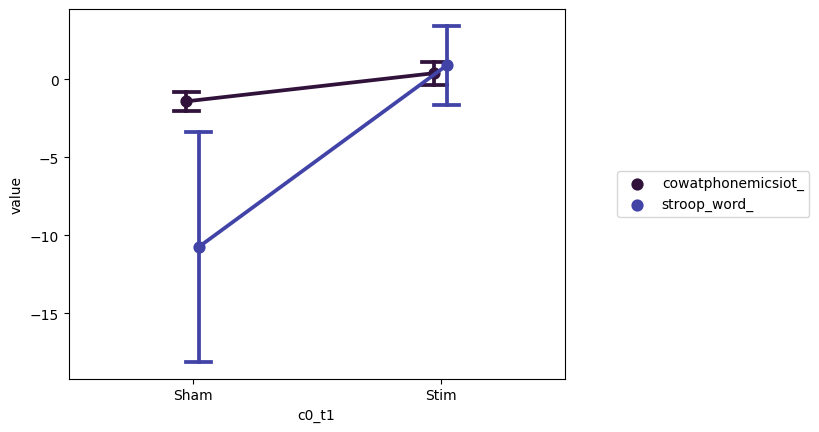

In [8]:
for h in hue:
    a = dh[(dh.c0_t1=='Sham')&(dh.variable==h)].value
    b = dh[(dh.c0_t1=='Stim')&(dh.variable==h)].value
    tval, pval = stats.ttest_ind(a,b,alternative='less')
    print('%s: %.3f (%s)'%(h,pval,convert_pvalue_to_asterisks(pval)))
    if pval > 0.05:
        dh.drop(dh[dh.variable==h].index, inplace=True)

g = sns.pointplot(
    data=dh,
    x='c0_t1', y='value',
    hue='variable', palette=cm.turbo(np.linspace(0,1,len(hue))),
    errorbar='se', capsize=0.1,
    dodge=True
)

g.legend(bbox_to_anchor=(1.3, 0.5), loc='center', ncol=1)

In [9]:
dh

,tms_id,no,c0_t1,variable,value
210,S05,1,Sham,cowatphonemicsiot_,0.0
211,S06,1,Sham,cowatphonemicsiot_,-3.0
212,S09,1,Stim,cowatphonemicsiot_,0.0
213,S10,1,Sham,cowatphonemicsiot_,-5.0
214,S11,1,Stim,cowatphonemicsiot_,0.0
215,S12,1,Stim,cowatphonemicsiot_,1.0
216,S14,1,Sham,cowatphonemicsiot_,1.0
217,S15,1,Stim,cowatphonemicsiot_,1.0
218,S17,1,Sham,cowatphonemicsiot_,-1.0
219,S18,1,Sham,cowatphonemicsiot_,-2.0


---

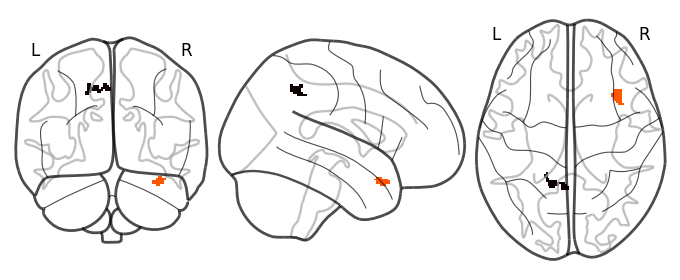

In [10]:
mask = join(dir_mask,'mask.Clust_mask.NN=1.p=0.01.stat_lHP.nii')
plotting.plot_glass_brain(mask)

In [11]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=mask, memory='/home/sungbeenpark/trash/nilearn_cache', verbose=0
    , labels=['right_temporal_pole', 'precuneus']
)

In [12]:
list_fname = np.concatenate(
    [
        glob(join(dir_corr,'3dTcorr1D.lHP.S??.pre.GlobalSignalRemoved=false.nii')),
        glob(join(dir_corr,'3dTcorr1D.lHP.S??.post.GlobalSignalRemoved=false.nii'))
    ]
)
list_fname.sort()

In [13]:
dp = pd.DataFrame()

for fname in tqdm(list_fname):
    subj = fname.split('/')[-1].split('.')[2]
    if not subj[1:] in list_subj:
        continue
    phase = 'Post' if '.post.' in fname else ('Pre' if '.pre.' in fname else 'invalid')
    gg = dg.loc[subj,'c0_t1']
    group = 'Sham' if gg==0 else ('Stim' if gg==1 else 'invalid')
    correlations = masker.fit_transform(fname)[0]
    for jj, roi in enumerate(masker.labels):
        new_row = pd.Series(
            {
                'subj':subj, 'phase':phase, 'group':group,
                'roi':roi, 'Pearson_r':correlations[jj]
            }
        )
        dp = pd.concat(
            [dp, new_row.to_frame().T]
            , axis='index'
            , ignore_index=True
        )
dp

100%|██████████| 56/56 [00:01<00:00, 35.68it/s] 


,subj,phase,group,roi,Pearson_r
0,S12,Post,Stim,right_temporal_pole,0.003266
1,S12,Post,Stim,precuneus,0.034387
2,S12,Pre,Stim,right_temporal_pole,0.206359
3,S12,Pre,Stim,precuneus,0.055457
4,S17,Post,Sham,right_temporal_pole,0.02125
...,...,...,...,...,...
75,S47,Pre,Stim,precuneus,0.045202
76,S48,Post,Stim,right_temporal_pole,-0.063307
77,S48,Post,Stim,precuneus,0.111369
78,S48,Pre,Stim,right_temporal_pole,-0.068673


right_temporal_pole, Pre (Sham vs. Stim) : 0.046 (*)
right_temporal_pole, Pre (Sham vs. Stim) : 0.016 (*)
right_temporal_pole, Stim (Pre vs. Post) : 0.0444 (*)
right_temporal_pole, Sham (Pre vs. Post) : 0.0006 (***)
precuneus, Pre (Sham vs. Stim) : 0.074 (ns)
precuneus, Pre (Sham vs. Stim) : 0.001 (**)
precuneus, Stim (Pre vs. Post) : 0.0020 (**)
precuneus, Sham (Pre vs. Post) : 0.0050 (**)


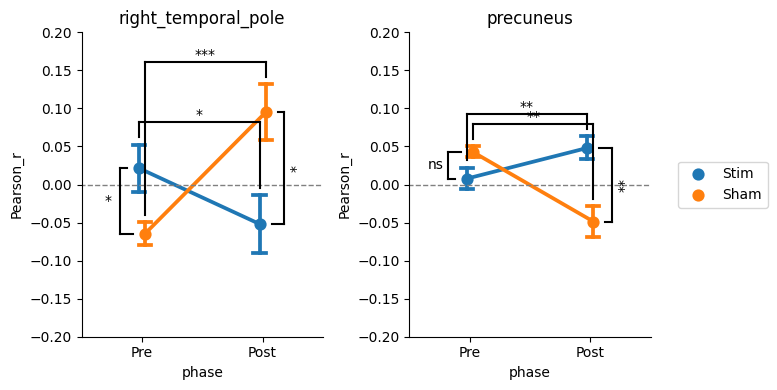

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

for ii, roi in enumerate(masker.labels):
    ax = axs[ii]
    g = sns.pointplot(
        data=dp[dp.roi==roi], x='phase', y='Pearson_r', hue='group',
        order=['Pre', 'Post'],
        errorbar='se', capsize=0.1,
        dodge=True,
        ax=ax
    )
    g.set_title(roi)
    g.get_legend().remove()
    g.set_ylim(-0.2,0.2)
    g.set_xlim(-0.5,1.5)
    g.hlines(
        y=0,
        xmin=-1, xmax=2,
        linestyle='--', color='gray', linewidth=1.0
    )
    
    ## In Pre, Stim vs. Sham
    a = dp[(dp.roi==roi)&(dp.group=='Sham')&(dp.phase=='Pre')].Pearson_r
    b = dp[(dp.roi==roi)&(dp.group=='Stim')&(dp.phase=='Pre')].Pearson_r
    tval, pval = stats.ttest_ind(a.astype(float),b.astype(float),alternative='two-sided')
    print('%s, Pre (Sham vs. Stim) : %.3f (%s)'%(roi, pval, convert_pvalue_to_asterisks(pval)))
    dx = 0.025
    g.plot([-0.1+dx,-0.18], [a.mean(),a.mean()], color='black', linestyle='-')
    g.plot([-0.1-dx,-0.18], [b.mean(),b.mean()], color='black', linestyle='-')
    g.plot([-0.18,-0.18], [a.mean(),b.mean()], color='black', linestyle='-')
    g.text(
        -0.28, (a.mean()+b.mean())*0.5, convert_pvalue_to_asterisks(pval)
        , ha='center', va='center', rotation=0, size=10
        , color='black'
    )
    
    ## In Post, Stim vs. Sham
    a = dp[(dp.roi==roi)&(dp.group=='Sham')&(dp.phase=='Post')].Pearson_r
    b = dp[(dp.roi==roi)&(dp.group=='Stim')&(dp.phase=='Post')].Pearson_r
    tval, pval = stats.ttest_ind(a.astype(float),b.astype(float),alternative='two-sided')
    print('%s, Pre (Sham vs. Stim) : %.3f (%s)'%(roi, pval, convert_pvalue_to_asterisks(pval)))
    dx = 0.025
    g.plot([1.1+dx,1.18], [a.mean(),a.mean()], color='black', linestyle='-')
    g.plot([1.1-dx,1.18], [b.mean(),b.mean()], color='black', linestyle='-')
    g.plot([1.18,1.18], [a.mean(),b.mean()], color='black', linestyle='-')
    g.text(
        1.28, (a.mean()+b.mean())*0.5, convert_pvalue_to_asterisks(pval)
        , ha='center', va='center', rotation=90, size=10
        , color='black'
    )

    ## Paired T-Test
    for group in ['Stim','Sham']:
        a = dp[(dp.roi==roi)&(dp.group==group)&(dp.phase=='Pre')].Pearson_r
        b = dp[(dp.roi==roi)&(dp.group==group)&(dp.phase=='Post')].Pearson_r
        tval, pval = stats.ttest_rel(a,b,alternative='two-sided')
        print('%s, %s (Pre vs. Post) : %.4f (%s)'%(roi, group, pval, convert_pvalue_to_asterisks(pval)))
        if pval < 0.5:
            if group=='Stim':
                dx = -0.025
            else:
                dx = 0.025
            x1, x2 = 0+dx, 1+dx
            y1, y2 = a.mean()+a.sem(), b.mean()+b.sem()
            yt = max(y1,y2)+0.03
            dy = 0.01
            g.plot([x1,x1], [y1+dy,yt], color='black', linestyle='-')
            g.plot([x2,x2], [y2+dy,yt], color='black', linestyle='-')
            g.plot([x1,x2], [yt,yt], color='black', linestyle='-')
            g.text(
                (x1+x2)*0.5, yt, convert_pvalue_to_asterisks(pval)
                , ha='center', va='bottom', rotation=0, size=10
                , color='black'
            )

g.legend(bbox_to_anchor=(1.3,0.5), loc='center', ncol=1)
            
sns.despine()
fig.tight_layout()

---

y : $\Delta$Performance (post - pre) \
x : $\Delta$Pearson (post - pre) \
hue : stim vs. sham

x

In [15]:
dp.Pearson_r = dp.Pearson_r.astype(float)
dp.set_index('subj', inplace=True)

y

In [16]:
dh.set_index('tms_id', inplace=True)

new dataframe

In [22]:
da = pd.DataFrame()

for nn in list_subj:
    subj = 'S%s'%nn
    gg = dg.loc[subj,'c0_t1']
    group = 'Sham' if gg==0 else ('Stim' if gg==1 else 'invalid')
    for roi in masker.labels:
        x = dp[(dp.roi==roi)&(dp.phase=='Post')].Pearson_r - dp[(dp.roi==roi)&(dp.phase=='Pre')].Pearson_r
        for var in dh.variable.unique():
            y = dh[dh.variable==var].value    
            new_row = pd.Series(
                {
                    'subj':subj, 'group':group,
                    'score_name':var, 'delta_score':y[subj],
                    'roi':roi, 'delta_r':x[subj]
                }
            )
            da = pd.concat(
                [da, new_row.to_frame().T]
                , axis='index'
                , ignore_index=True
            )
da.delta_score = da.delta_score.astype(float)
da.delta_r = da.delta_r.astype(float)
da

,subj,group,score_name,delta_score,roi,delta_r
0,S12,Stim,cowatphonemicsiot_,1.0,right_temporal_pole,-0.203093
1,S12,Stim,stroop_word_,0.0,right_temporal_pole,-0.203093
2,S12,Stim,cowatphonemicsiot_,1.0,precuneus,-0.021070
3,S12,Stim,stroop_word_,0.0,precuneus,-0.021070
4,S17,Sham,cowatphonemicsiot_,-1.0,right_temporal_pole,0.114130
...,...,...,...,...,...,...
75,S47,Stim,stroop_word_,0.0,precuneus,0.006580
76,S48,Stim,cowatphonemicsiot_,4.0,right_temporal_pole,0.005366
77,S48,Stim,stroop_word_,0.0,right_temporal_pole,0.005366
78,S48,Stim,cowatphonemicsiot_,4.0,precuneus,0.073742


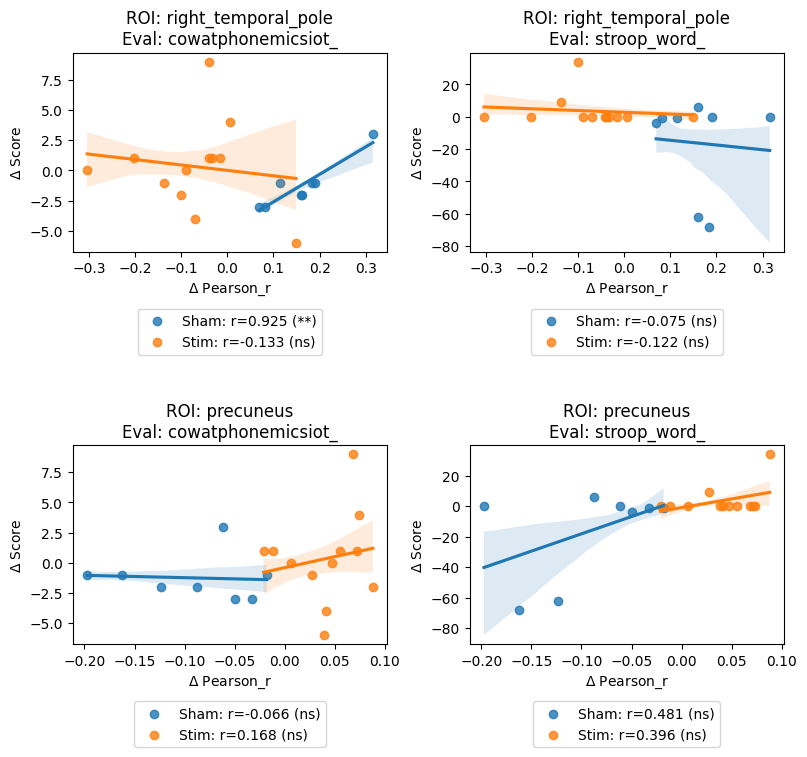

In [44]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

for ii, roi in enumerate(masker.labels):
    for jj, var in enumerate(dh.variable.unique()):
        ax = axs[ii,jj]
        tmp = da[(da.roi==roi)&(da.score_name==var)]
        for group in ['Sham', 'Stim']:
            x = tmp[tmp.group==group].delta_r
            y = tmp[tmp.group==group].delta_score
            r, pval = stats.pearsonr(x,y)
            g = sns.regplot(
                data=tmp[tmp.group==group], x='delta_r', y='delta_score',
                ci=68,
                ax=ax, label='%s: r=%.3f (%s)'%(group,r,convert_pvalue_to_asterisks(pval))
            )
            g.set_title('ROI: %s\nEval: %s'%(roi,var))
            g.legend(bbox_to_anchor=(0.5,-0.4), loc='center', ncol=1)
            g.set_ylabel(r'$\Delta$ Score')
            g.set_xlabel(r'$\Delta$ Pearson_r')
    
fig.tight_layout()